In [16]:
import pandas as pd
import os

# --- Lectura de archivos principales ---
dolar_df = pd.read_csv("tipos-de-cambio-historicos.csv")
inflacion_df = pd.read_excel("inflacion.xlsx")
merval_df = pd.read_csv("MERVAL - Cotizaciones historicas.csv")

def standardize_date_column(df, possible_columns):
    """Busca y renombra la columna de fecha a 'Fecha' si la encuentra."""
    for col in possible_columns:
        if col in df.columns:
            df['Fecha'] = pd.to_datetime(df[col], errors='coerce')
            return df
    print(f"Advertencia: No se encontró una columna de fecha estándar en el DataFrame. Columnas presentes: {df.columns}")
    return df

# --- Estandarización de columnas de fecha ---
dolar_df = standardize_date_column(dolar_df, ['indice_tiempo', 'Fecha'])
inflacion_df = standardize_date_column(inflacion_df, ['indice_tiempo', 'Fecha'])
merval_df = standardize_date_column(merval_df, ['fecha', 'Fecha']) # Buscamos 'fecha' primero

# --- Reparar CSV del Merval (si es necesario) ---
if merval_df.shape[1] == 1 and "," in merval_df.columns[0]:
    raw = pd.read_csv("MERVAL - Cotizaciones historicas.csv", header=None)
    merval_df = raw[0].str.split(",", expand=True)
    merval_df.columns = raw.iloc[0].tolist() # Usamos la primera fila del raw para los nombres
    merval_df = merval_df.drop(index=0).reset_index(drop=True)
    merval_df = standardize_date_column(merval_df, ['fecha', 'Fecha']) # Volvemos a estandarizar después de la reparación
else:
    merval_df = standardize_date_column(merval_df, ['fecha', 'Fecha']) # Si no necesita reparación, buscamos 'fecha'

# --- Unificación de tipos de cambio ---
columnas_dolar = [
    'dolar_tipo_unico', 'dolar_finan_esp_compra', 'dolar_finan_esp_venta',
    'dolar_financiero_compra', 'dolar_financiero_venta',
    'dolar_libre_compra', 'dolar_libre_venta',
    'dolar_oficial_compra', 'dolar_oficial_venta',
    'dolar_estadounidense', 'dolar_referencia_com_3500'
]
if 'tipo_cambio_unificado' not in dolar_df.columns:
    dolar_df['tipo_cambio_unificado'] = dolar_df[columnas_dolar].bfill(axis=1).iloc[:, 0]

# --- Unir DataFrames por 'Fecha' ---
dataframes_a_unir = {'dolar_df': dolar_df, 'merval_df': merval_df, 'inflacion_df': inflacion_df}
for name, df in dataframes_a_unir.items():
    if 'Fecha' in df.columns:
        df.set_index('Fecha', inplace=True)
    else:
        print(f"Error: El DataFrame '{name}' no tiene la columna 'Fecha' para establecer como índice.")

# --- Unir DataFrames ---
df_combinado = pd.concat([dataframes_a_unir['dolar_df'], dataframes_a_unir['merval_df'], dataframes_a_unir['inflacion_df']], axis=1, join='inner').reset_index()

# --- Leer archivos económicos adicionales ---
ruta_carpeta = "D:/Mis documentos/Estudio/Lic en economia/2do Año/Big data & machine learning/Tps/TP Grupal"
archivos = [
    "principales-tasas-interes-referencia-principales-economias-mundo-frecuencia-mensual.csv",
    "reservas-internacionales-pasivos-financieros-bcra.csv",
    "principales-tasas-interes.csv"
]
rutas = [os.path.join(ruta_carpeta, f) for f in archivos]
df_filtrado = pd.concat([pd.read_csv(r) for r in rutas], ignore_index=True)

# --- Filtrar columnas útiles y unir al combinado ---
columnas_utiles = [
    'indice_tiempo', 'reservas_internacionales_dolares', 'pasivos_monetarios', 'tipo_cambio_valuacion',
    'tasas_interes_plazo_fijo_30_59_dias', 'tasas_interes_call', 'tasas_interes_badlar',
    'instr_bcra_tasa_politica_monetaria', 'posicion_neta_pases', 'pos_neta_det_des_pases_pasivos'
]
if 'indice_tiempo' in df_filtrado.columns:
    df_economico = df_filtrado[columnas_utiles].copy()
    df_economico['Fecha'] = pd.to_datetime(df_economico['indice_tiempo'], errors='coerce')
    df_final = pd.merge(df_combinado, df_economico.drop(columns=['indice_tiempo']), on='Fecha', how='inner')
else:
    print("Advertencia: La columna 'indice_tiempo' no se encontró en df_filtrado.")
    df_final = df_combinado.copy() # Si no hay datos económicos, trabajamos solo con el combinado

# --- Resultado final ---
print(df_final[['Fecha', 'tipo_cambio_unificado', 'cierre', 'volumen', 'inflacion']].head())
print(df_final.columns)

Empty DataFrame
Columns: [Fecha, tipo_cambio_unificado, cierre, volumen, inflacion]
Index: []
Index(['Fecha', 'indice_tiempo', 'dolar_tipo_unico', 'dolar_finan_esp_compra',
       'dolar_finan_esp_venta', 'dolar_financiero_compra',
       'dolar_financiero_venta', 'dolar_libre_compra', 'dolar_libre_venta',
       'dolar_oficial_compra', 'dolar_oficial_venta', 'dolar_estadounidense',
       'dolar_referencia_com_3500', 'tipo_cambio_unificado', 'especie',
       'fecha', 'apertura', 'maximo', 'minimo', 'cierre', 'volumen',
       'timestamp', 'inflacion', 'reservas_internacionales_dolares',
       'pasivos_monetarios', 'tipo_cambio_valuacion',
       'tasas_interes_plazo_fijo_30_59_dias', 'tasas_interes_call',
       'tasas_interes_badlar', 'instr_bcra_tasa_politica_monetaria',
       'posicion_neta_pases', 'pos_neta_det_des_pases_pasivos'],
      dtype='object')


C:\Users\Brian Emanuel Rios\AppData\Local\Temp\ipykernel_16260\701535189.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  merval_mensual = df_merval.resample('M').last()


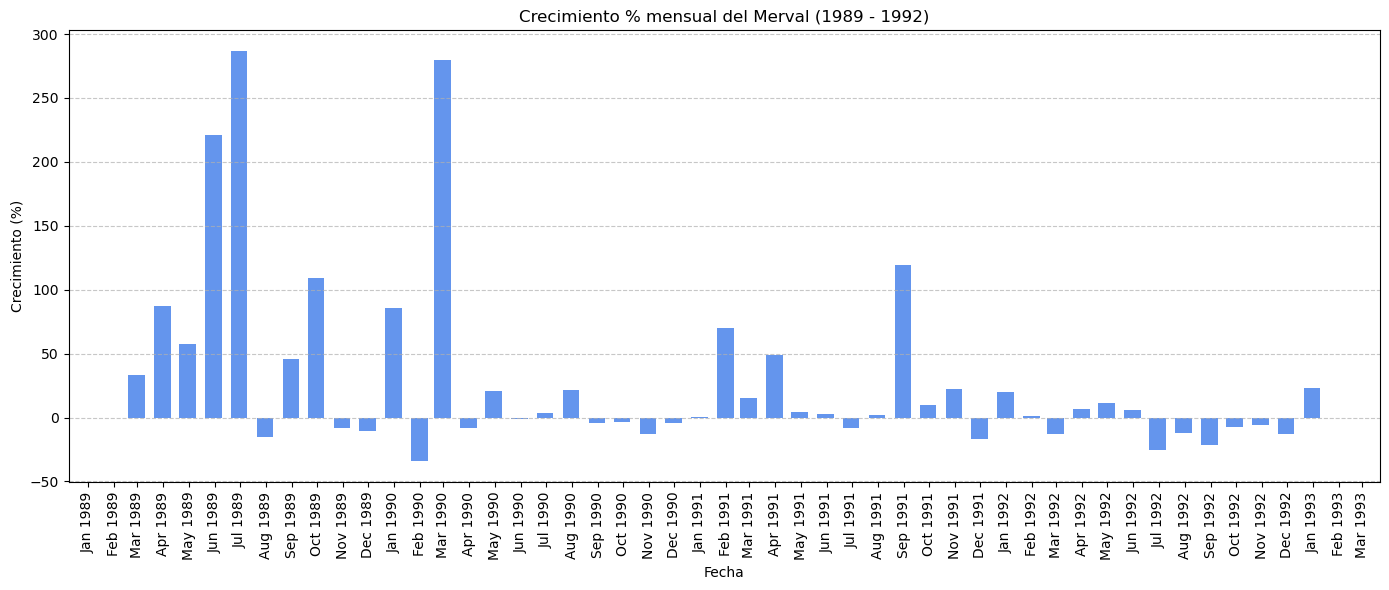

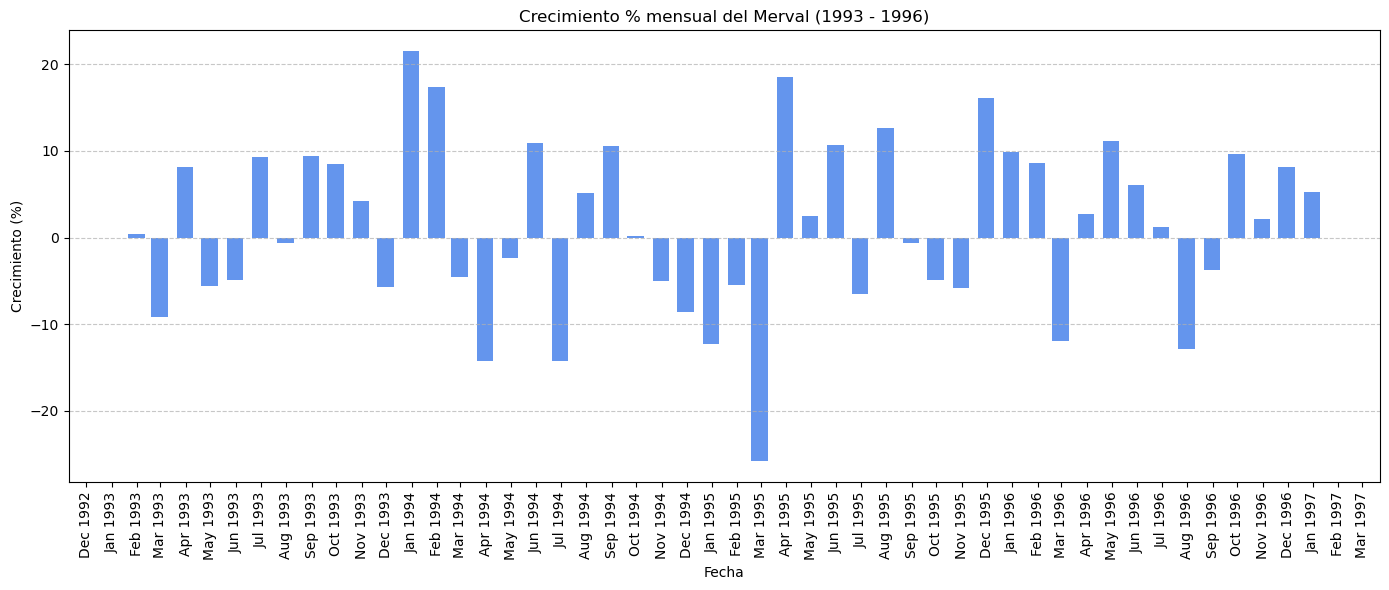

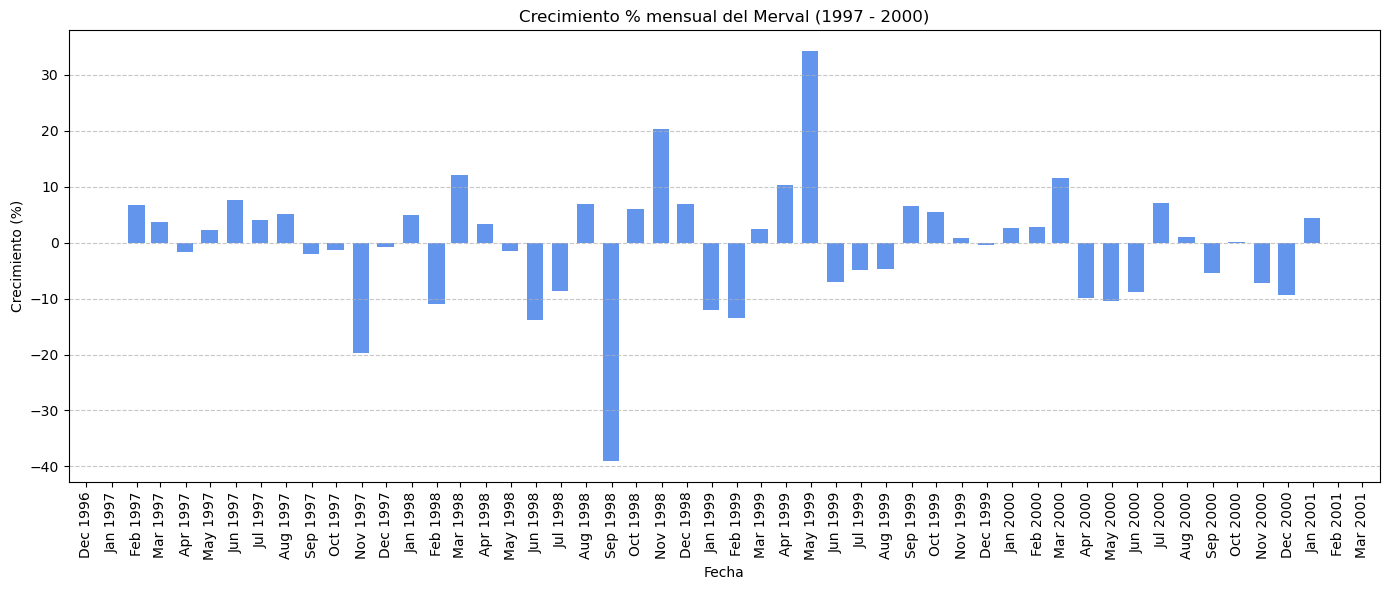

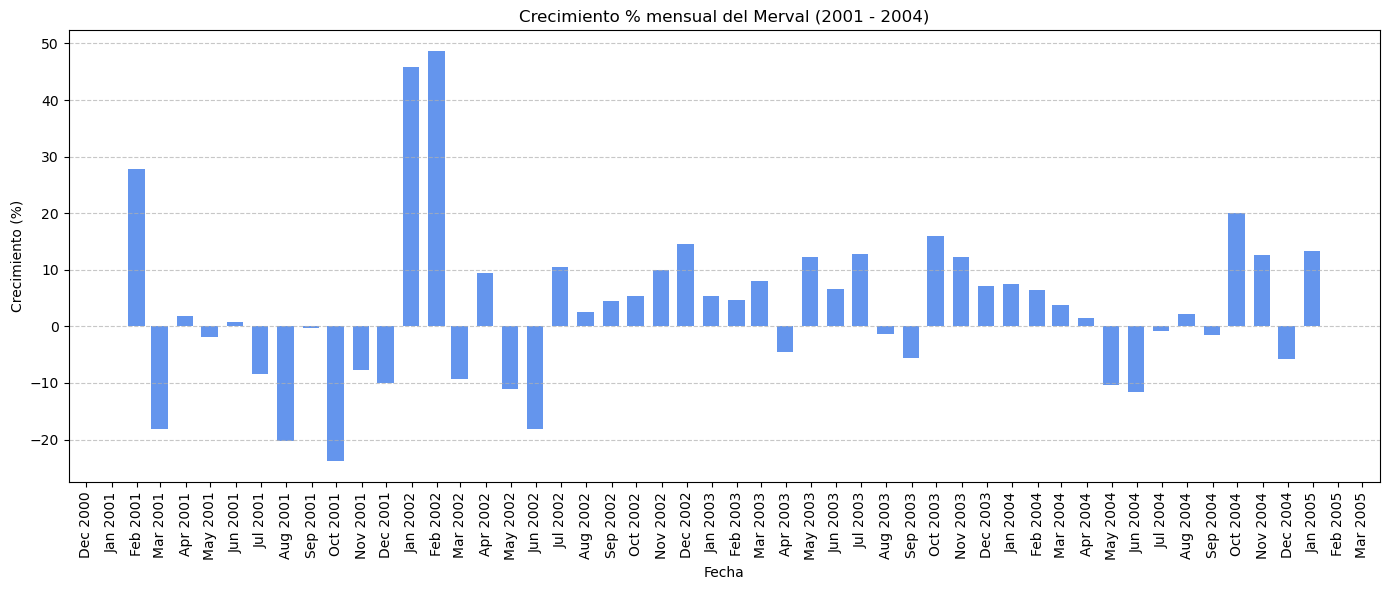

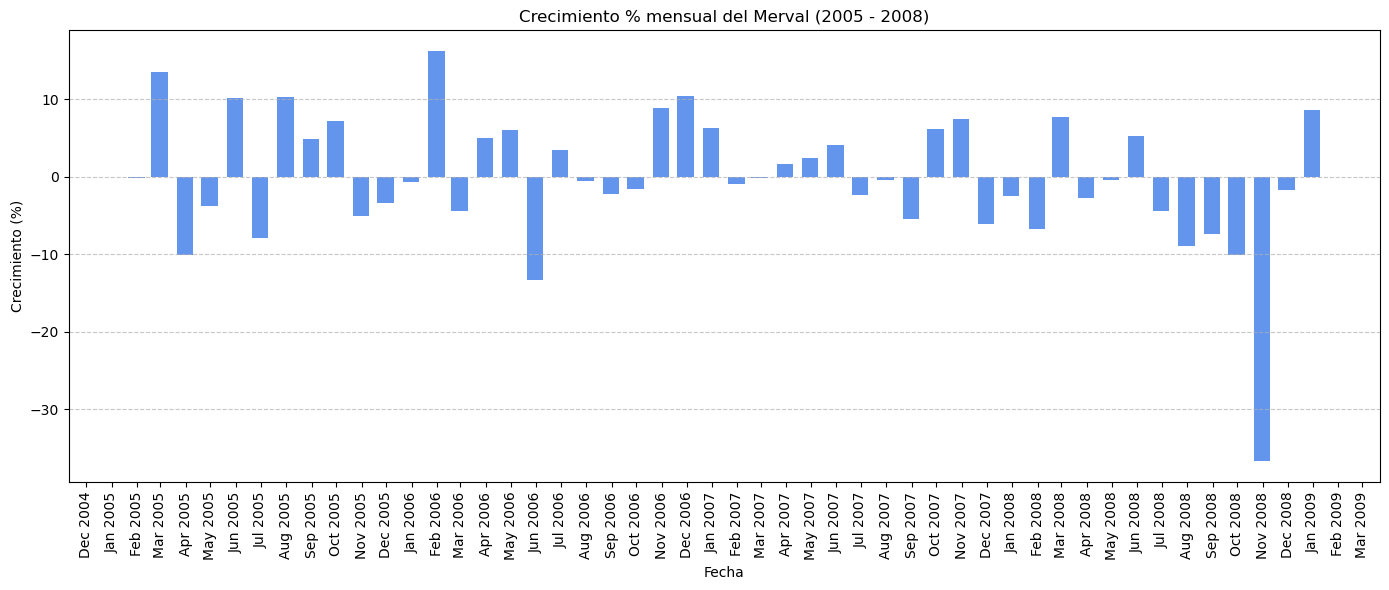

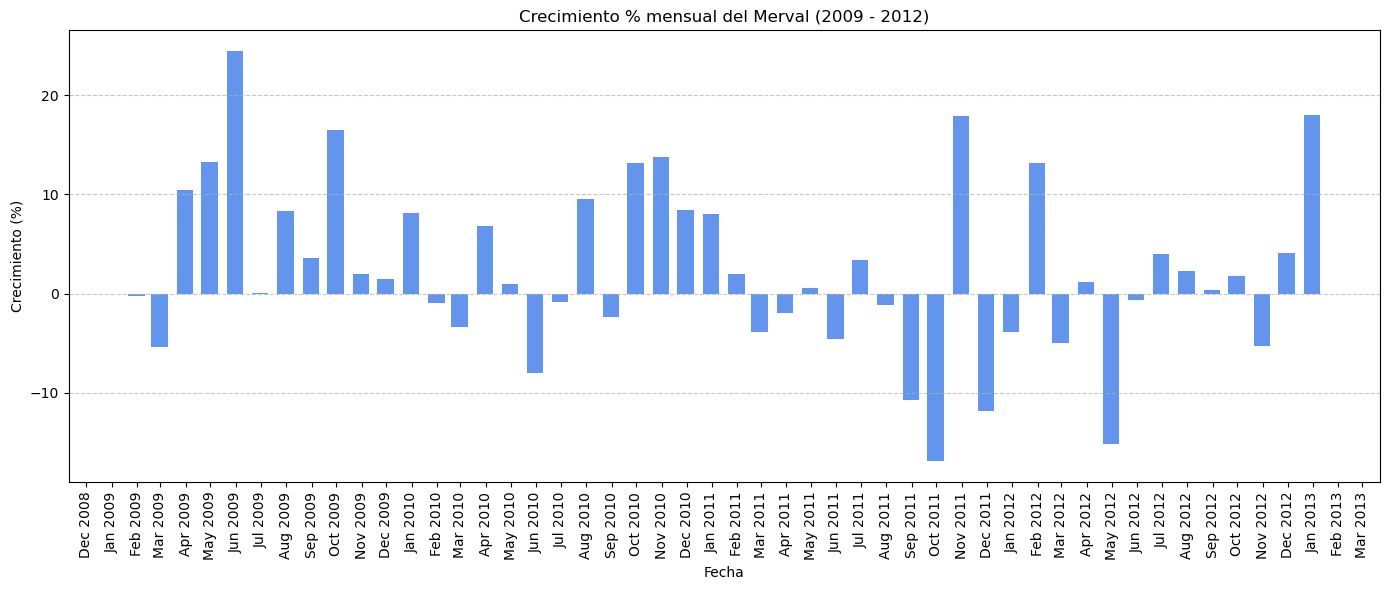

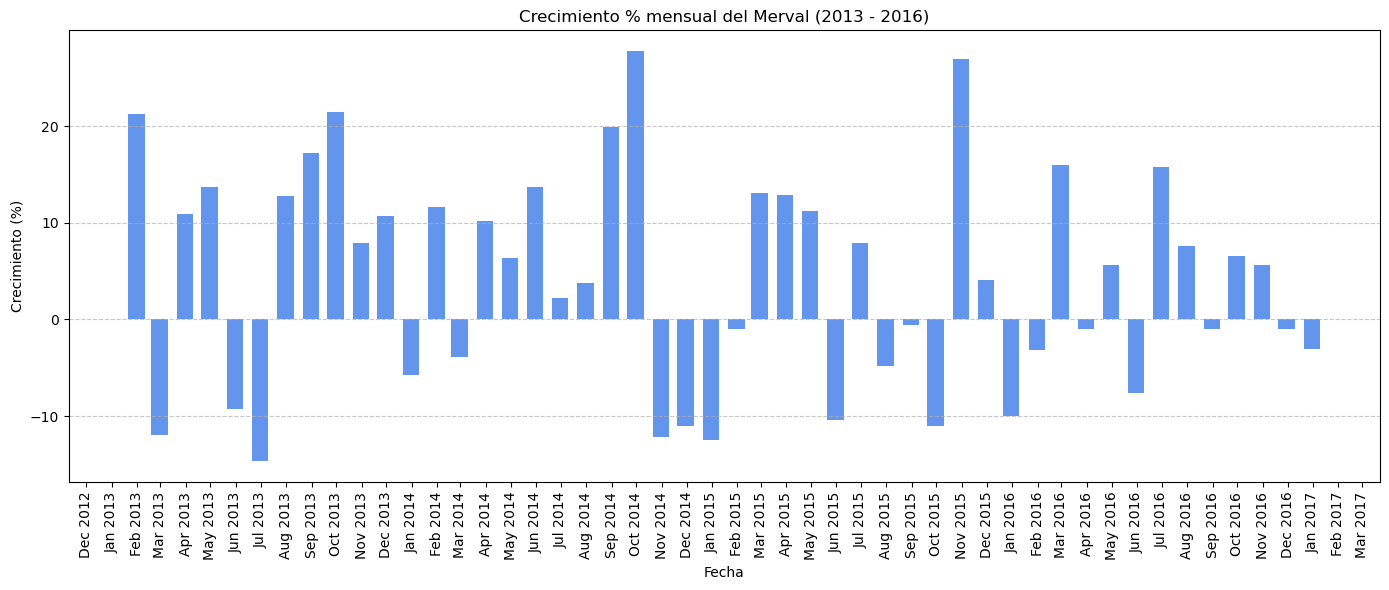

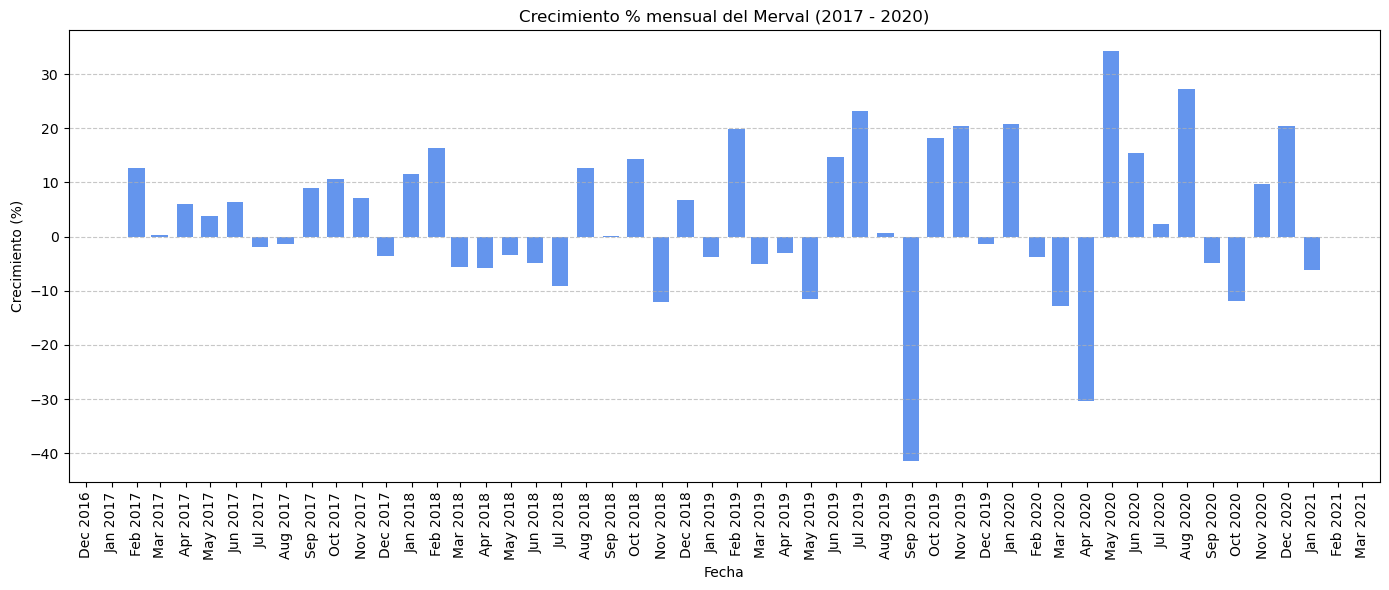

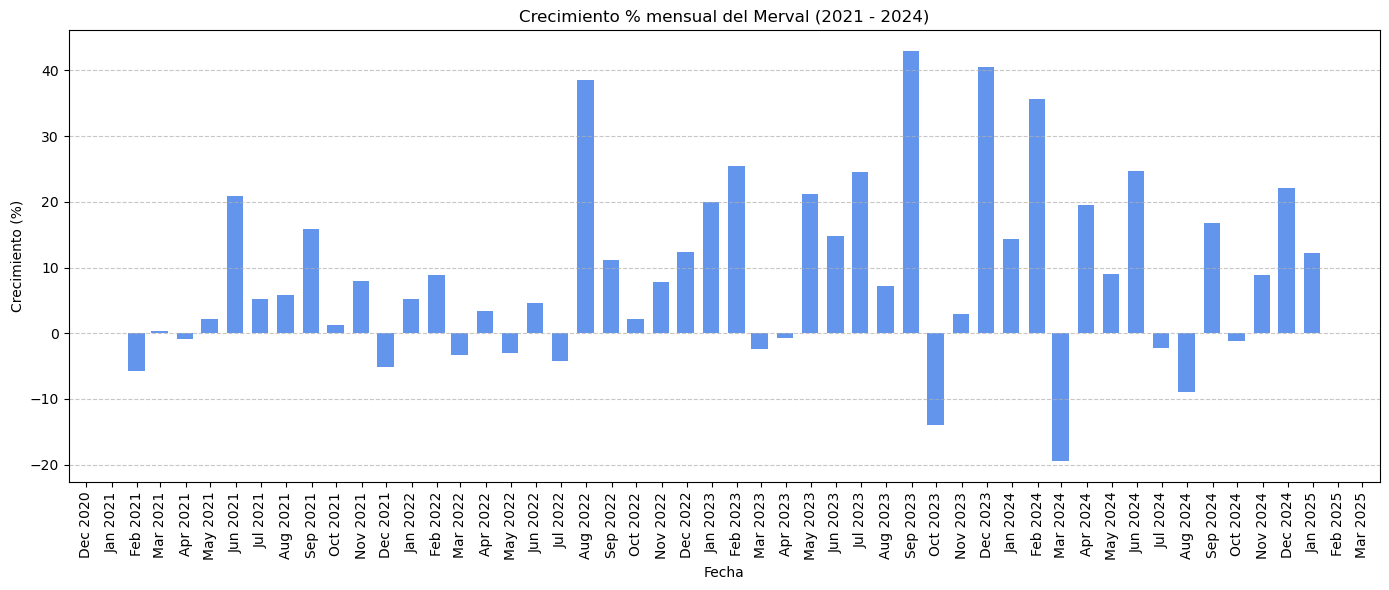

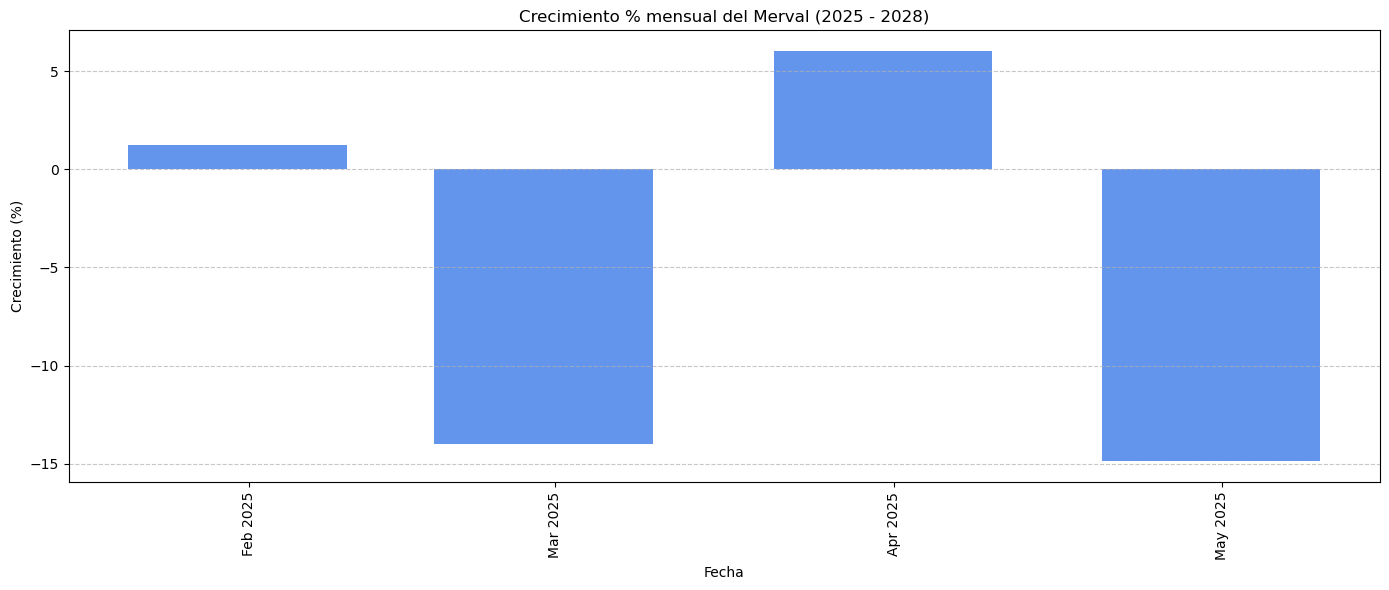

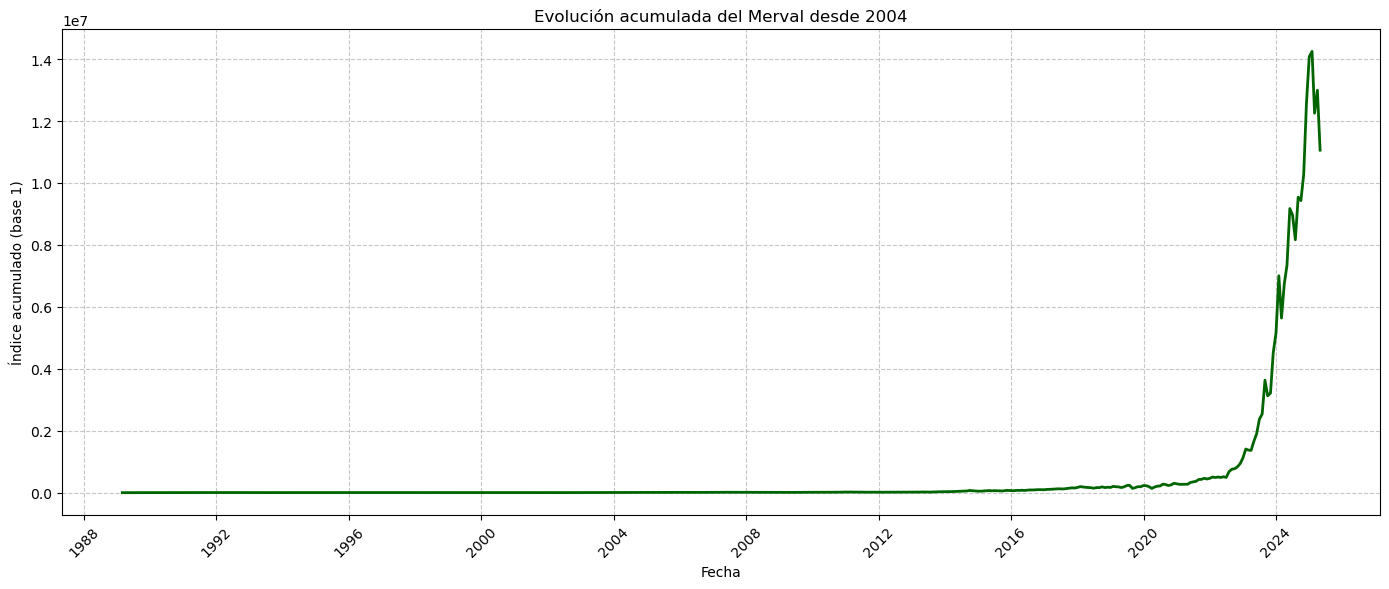

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Asegurarse que 'Fecha' es índice y está en formato datetime
df_merval = merval_df[['cierre']].dropna()
df_merval = df_merval[~df_merval.index.duplicated(keep='last')]
df_merval.index = pd.to_datetime(df_merval.index)

# Agrupar por mes: tomar el valor de cierre del mes
merval_mensual = df_merval.resample('M').last()

# Calcular % de crecimiento mensual
merval_mensual['crecimiento_pct'] = merval_mensual['cierre'].pct_change() * 100

# Calcular evolución acumulada del Merval
merval_mensual['merval_acumulado'] = (1 + merval_mensual['crecimiento_pct']/100).cumprod()

# --- GRAFICOS SEPARADOS CADA 4 AÑOS ---
start_year = merval_mensual.index.min().year
end_year = merval_mensual.index.max().year

for year in range(start_year, end_year + 1, 4):
    df_slice = merval_mensual[(merval_mensual.index.year >= year) & (merval_mensual.index.year < year + 4)]

    if df_slice.empty:
        continue  # Saltar si no hay datos en ese rango

    plt.figure(figsize=(14, 6))
    plt.bar(df_slice.index, df_slice['crecimiento_pct'], color='cornflowerblue', width=20)
    plt.title(f'Crecimiento % mensual del Merval ({year} - {year+3})')
    plt.ylabel('Crecimiento (%)')
    plt.xlabel('Fecha')
    
    # Mostrar etiquetas de meses en formato abreviado
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- GRAFICO DE EVOLUCIÓN ACUMULADA TOTAL ---
plt.figure(figsize=(14, 6))
plt.plot(merval_mensual.index, merval_mensual['merval_acumulado'], color='darkgreen', linewidth=2)
plt.title('Evolución acumulada del Merval desde 2004')
plt.ylabel('Índice acumulado (base 1)')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




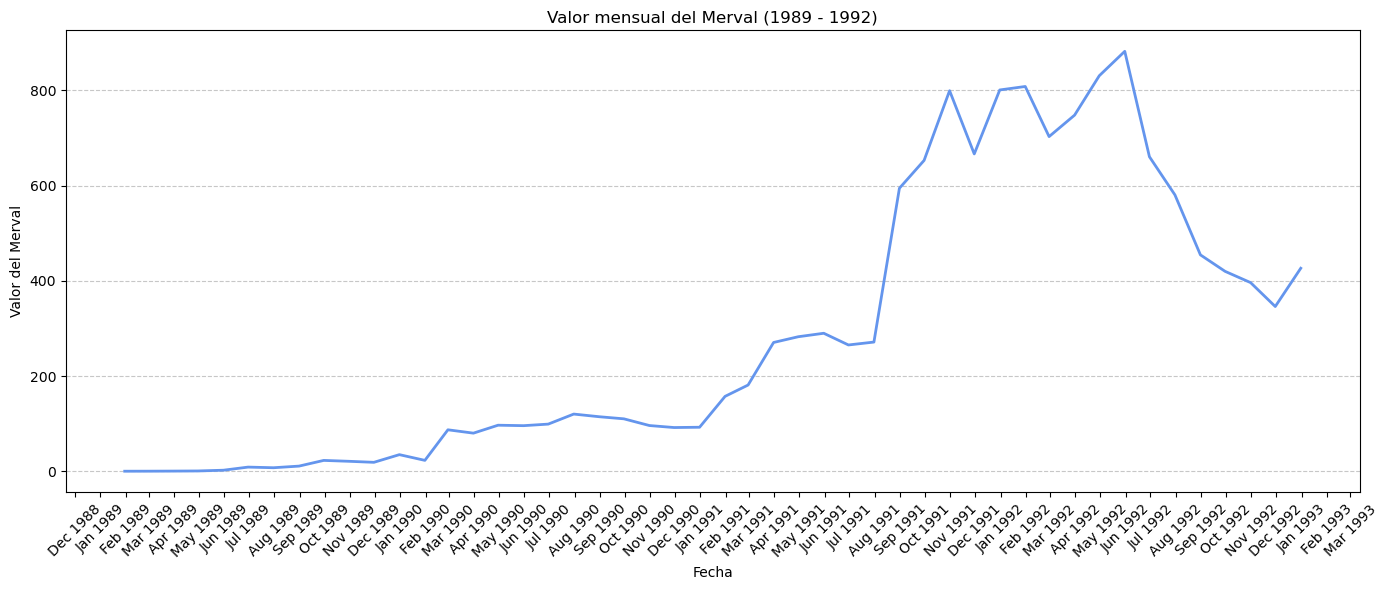

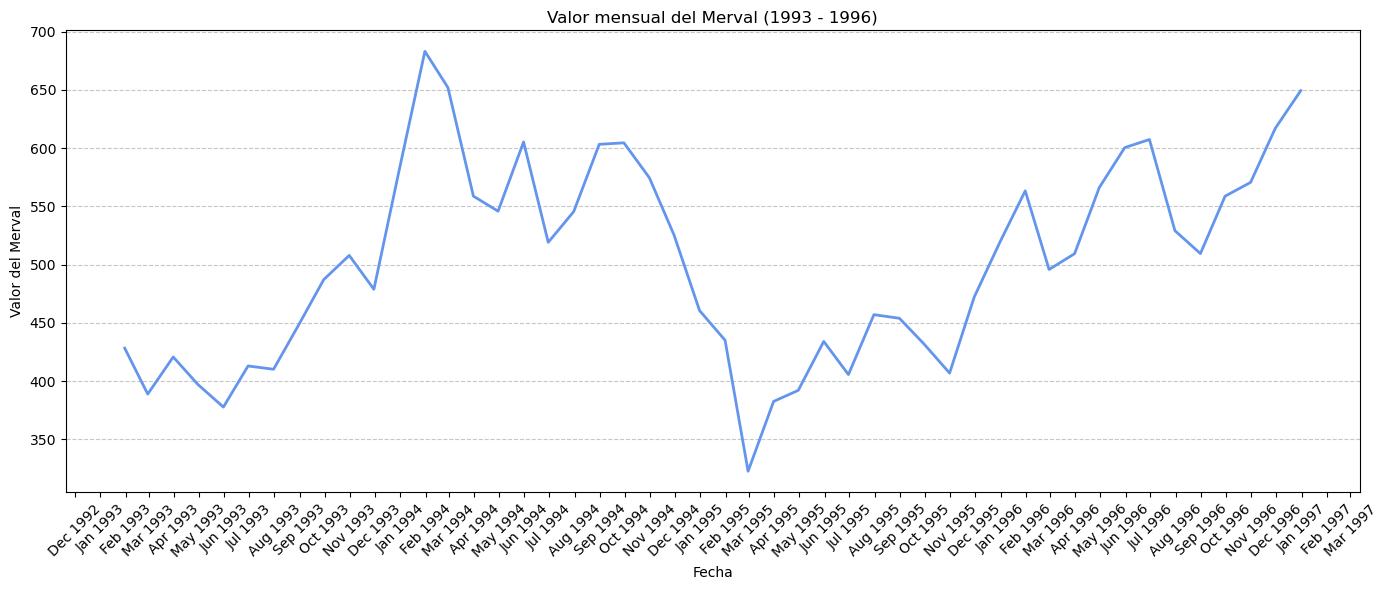

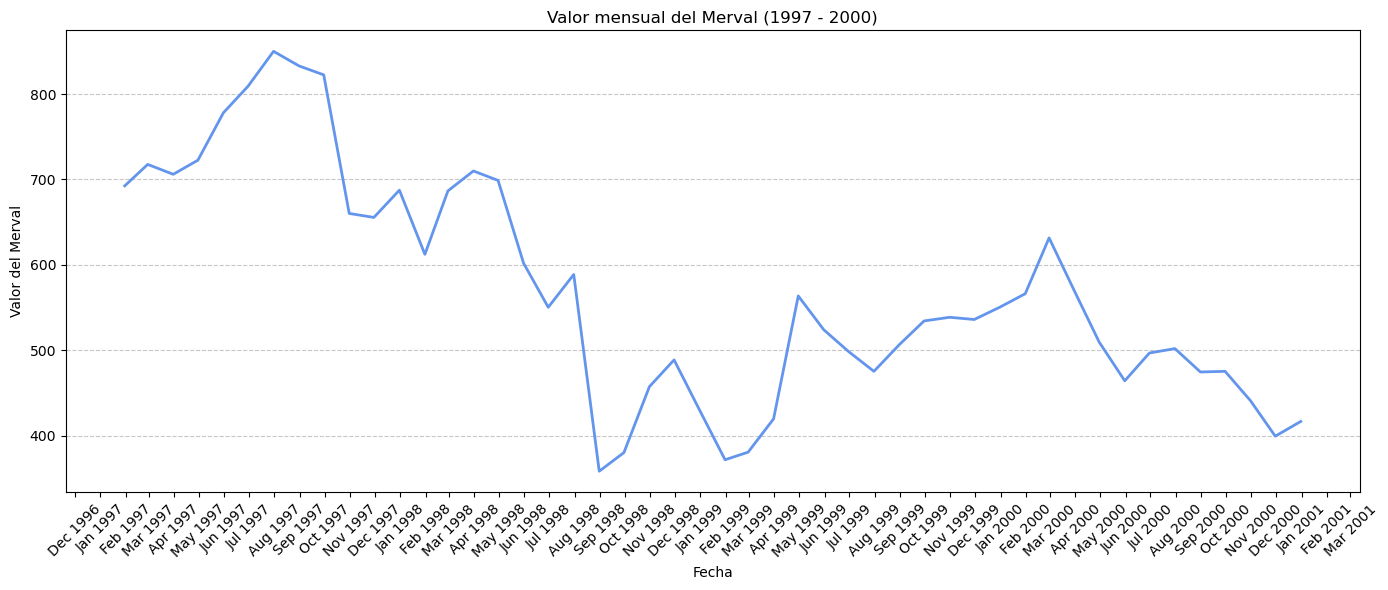

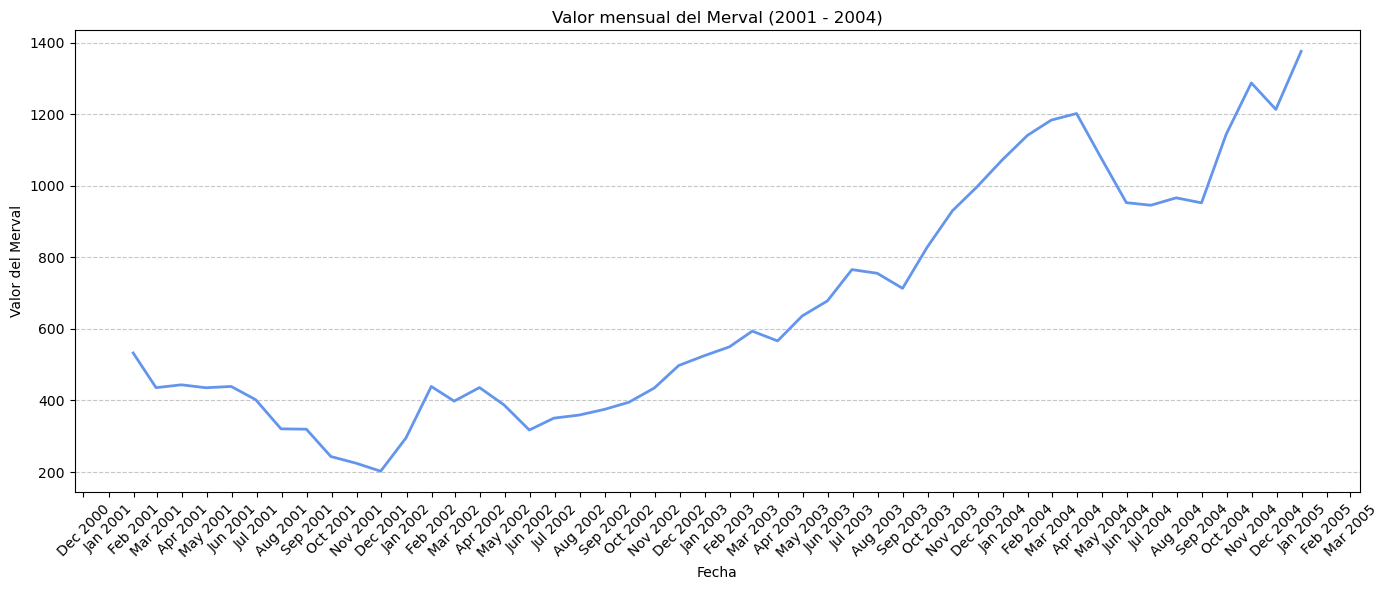

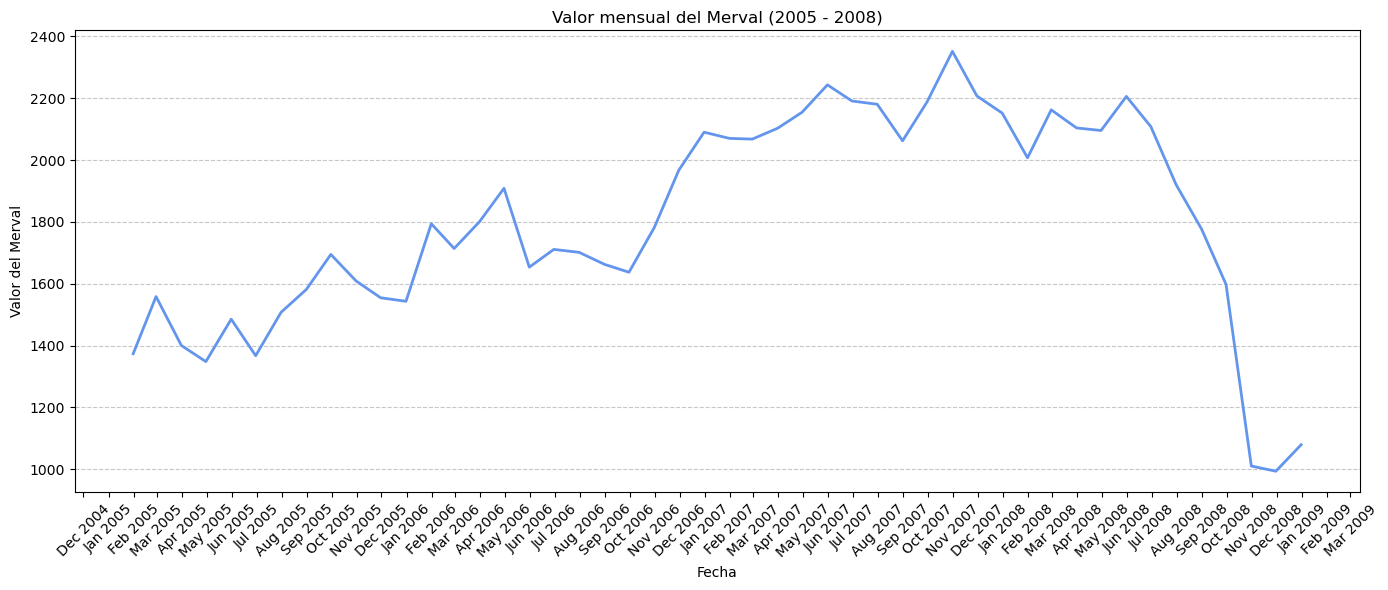

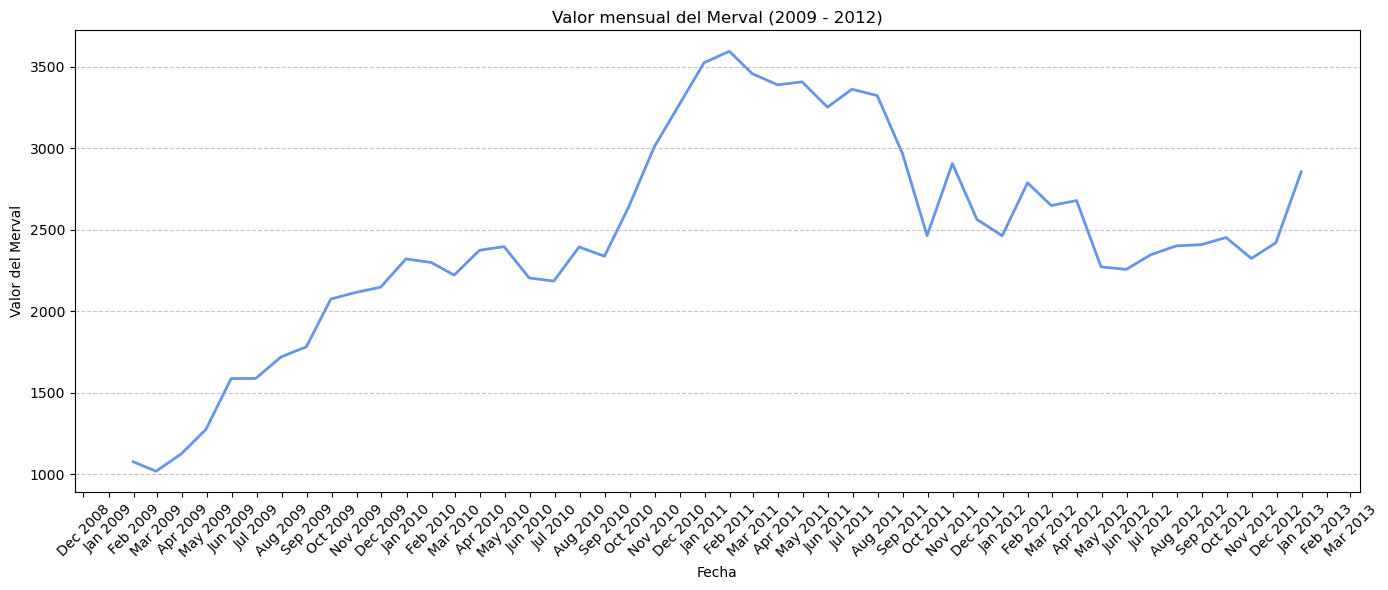

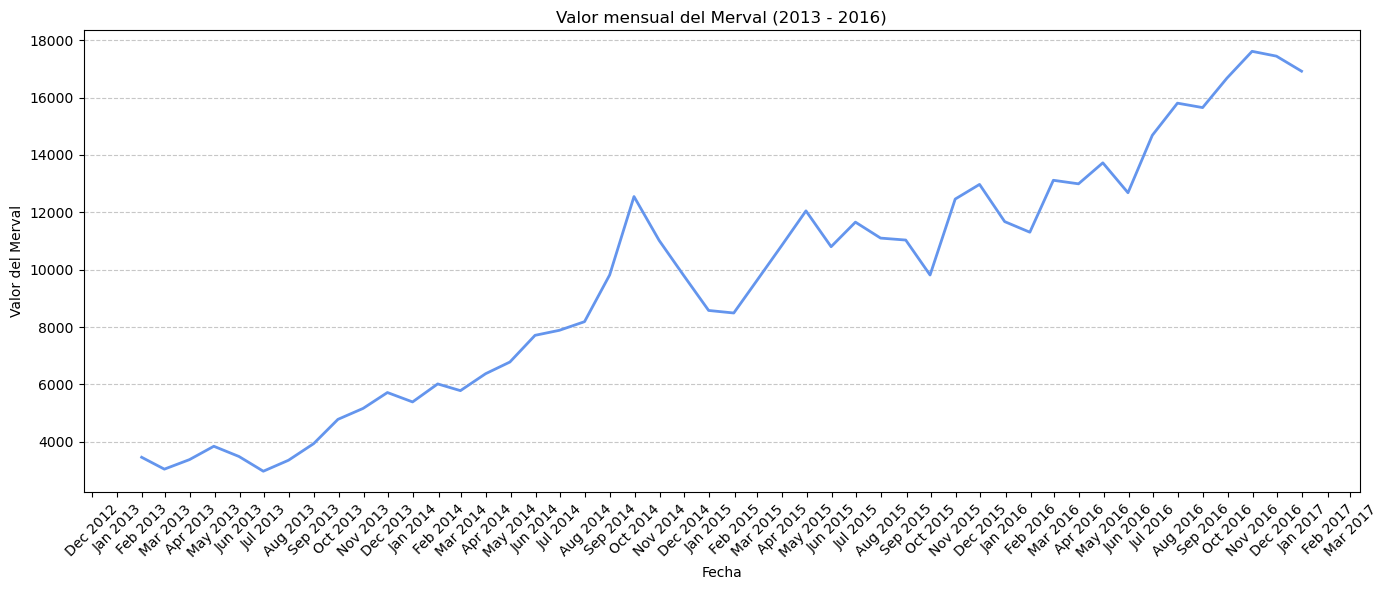

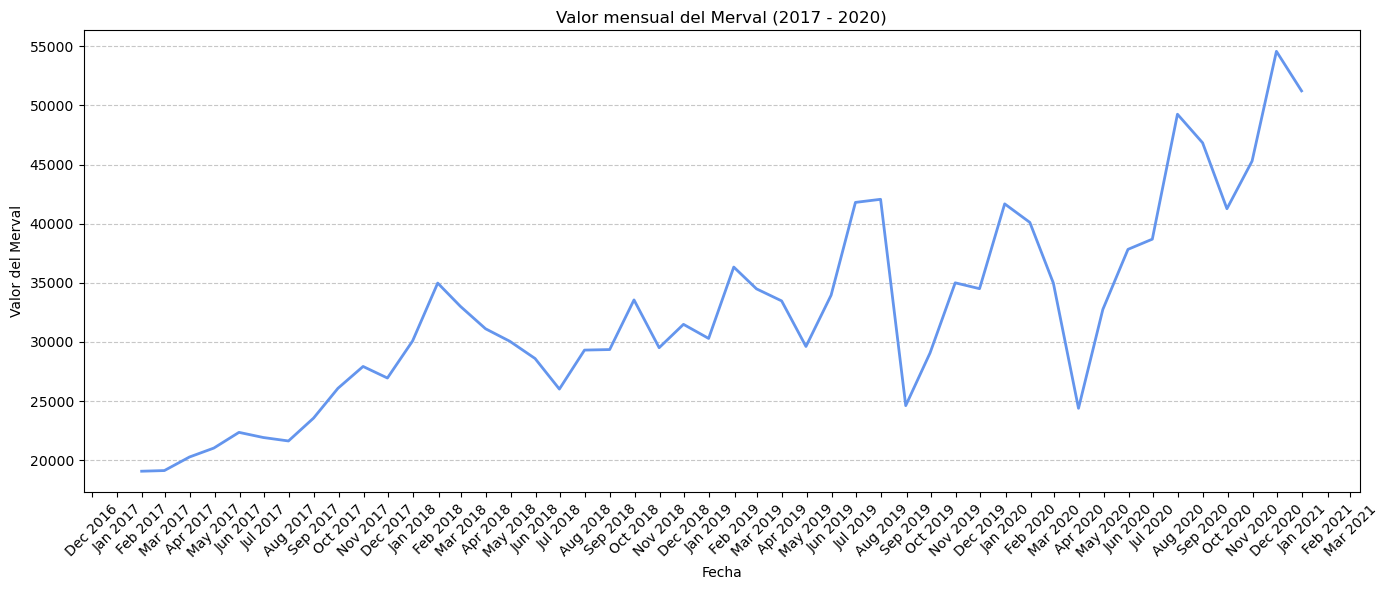

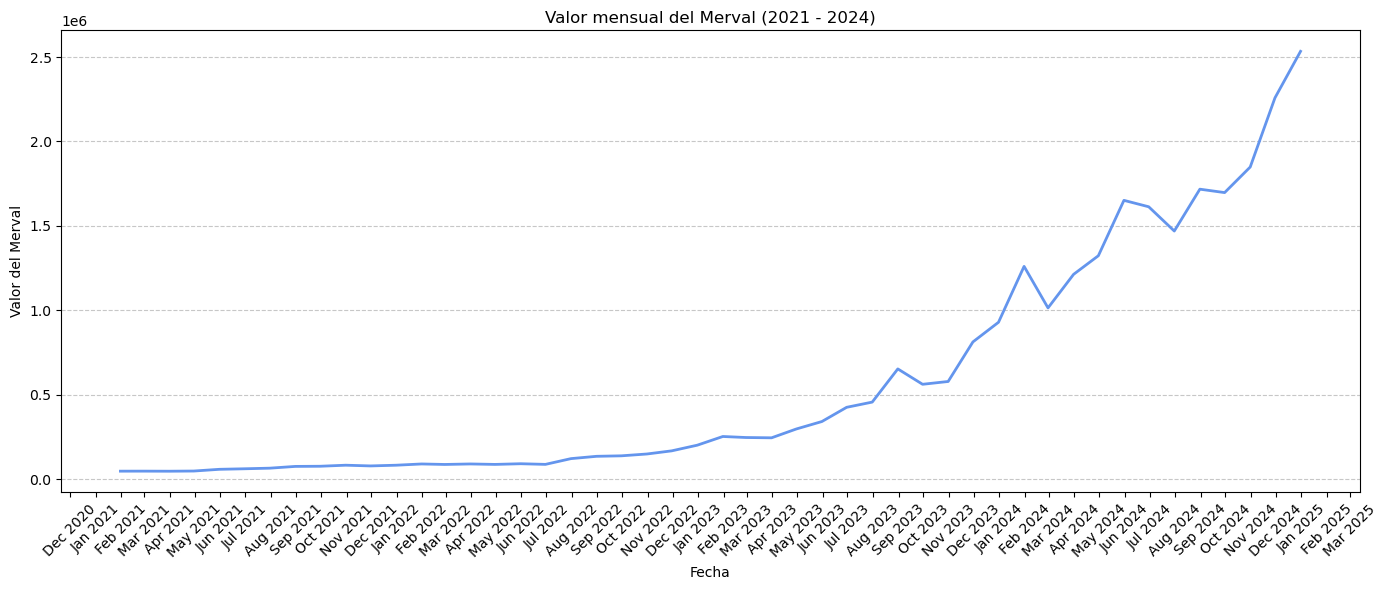

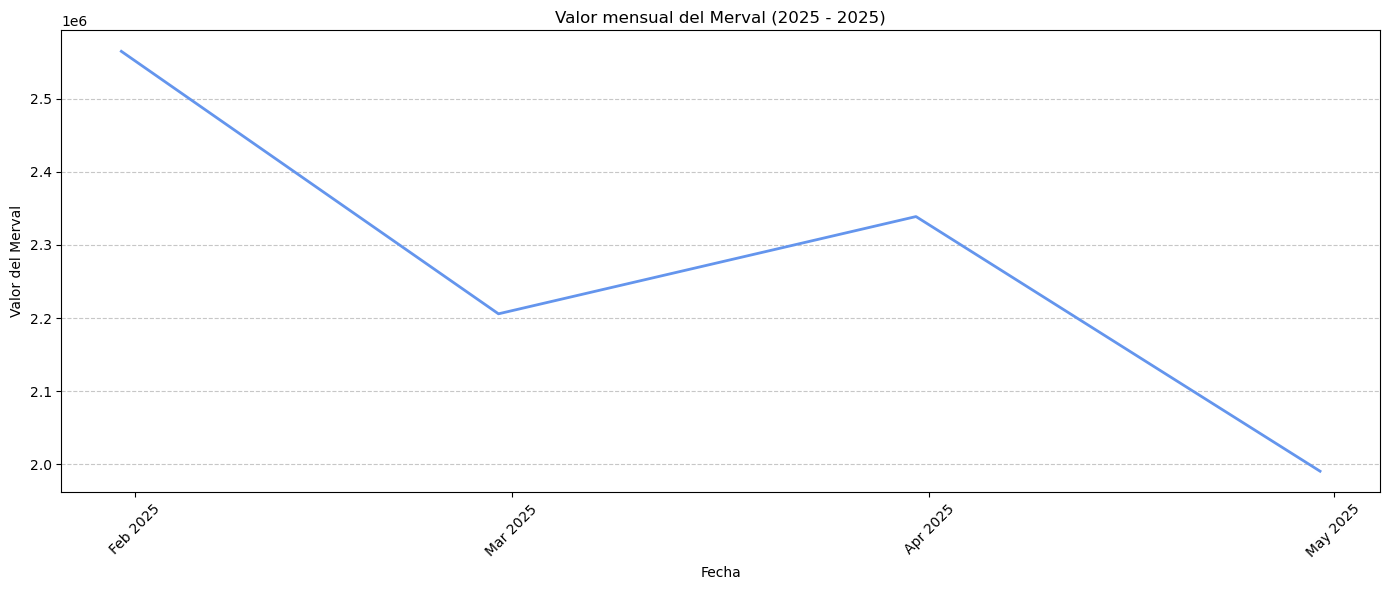

In [18]:
# Definir los intervalos de 4 años basados en el primer y último año de los datos
start_year = merval_mensual.index.min().year
end_year = merval_mensual.index.max().year

for year in range(start_year, end_year + 1, 4):
    start_period = pd.to_datetime(f'{year}-01-01')
    end_period = pd.to_datetime(f'{min(year + 4, end_year + 1)}-01-01')  # Asegura que el último período no exceda el final de los datos

    df_periodo = merval_mensual[(merval_mensual.index >= start_period) & (merval_mensual.index < end_period)]

    if df_periodo.empty:
        continue  # Saltar si no hay datos en este período

    plt.figure(figsize=(14, 6))
    plt.plot(df_periodo.index, df_periodo['cierre'], color='cornflowerblue', linewidth=2)
    plt.title(f'Valor mensual del Merval ({start_period.year} - {df_periodo.index[-1].year if not df_periodo.empty else ""})')
    plt.ylabel('Valor del Merval')
    plt.xlabel('Fecha')

    # Mostrar etiquetas de meses en formato abreviado
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()